## Incorporating the Reimannian metric A in optimization
Requires an optimization method that can take a Hessian or a Hessian-Product as input.

[SciPy Optimize Reference](http://docs.scipy.org/doc/scipy-0.14.0/reference/tutorial/optimize.html)

In [1]:
%matplotlib inline
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

In [19]:
class SDFSphere(object):
    def __init__(self, x, r):
        self.x = x
        self.r = r
    def sdf(self, p):
        return np.linalg.norm(p - self.x) - self.r
    def sdfgrad(self, p):
        import warnings
        with warnings.catch_warnings():
            warnings.filterwarnings('error')
            try:
                grad = (p - self.x)/np.linalg.norm(p - self.x)
            except Warning as e:
                grad = np.zeros(p.shape)
        return grad

class SDFAABB(object):
    def __init__(self, x, dim):
        self.x = x
        self.dim = dim
    def sdfandgrad(self, p):
        sdfgrad = np.zeros(p.shape)
        diff = (np.absolute(p - self.x) - self.dim)
        pos = diff[diff >= 0.]
        if pos.shape[0] == 0:
            sdf = np.max(diff)
            i = np.argmax(diff)
        else:
            sdf = np.linalg.norm(pos)
            i = np.where(diff >= 0.)
        sdfgrad[i] = 1
        sdfgrad = sdfgrad/np.linalg.norm(sdfgrad)
        return sdf, sdfgrad
    def sdf(self, p):
        return self.sdfandgrad(p)[0]
    def sdfgrad(self, p):
        return self.sdfandgrad(p)[1]
            
class SDFSoup(object):
    def __init__(self, geoms):
        self.geoms = geoms
    def sdf(self, p):
        return np.min([s.sdf(p) for s in self.geoms])
    def sdfgrad(self, p):
        i = np.argmin([s.sdf(p) for s in self.geoms])
        return self.spheres[i].sdfgrad(p)

In [36]:
geoms = []
geoms.append(SDFSphere(np.asarray([0.25, 0.25]), 0.2))
geoms.append(SDFSphere(np.asarray([0.75, 0.75]), 0.2))
geoms.append(SDFAABB(np.asarray([0.5, 0.5]), np.asarray([0.2, 0.2])))
sdf = SDFSoup(geoms)

In [40]:
def c(sdf, eps, k):
    if (sdf > eps):
        return 0.
    elif (sdf > 0.):
        return (k/2)*(sdf - eps)**2
    else:
        return k*eps*((eps/2) - sdf)

In [41]:
# From http://stackoverflow.com/questions/20144529/shifted-colorbar-matplotlib
from matplotlib.colors import Normalize

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

<matplotlib.colorbar.Colorbar instance at 0x114f39b90>

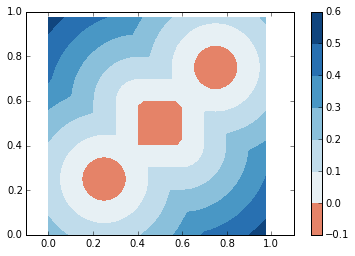

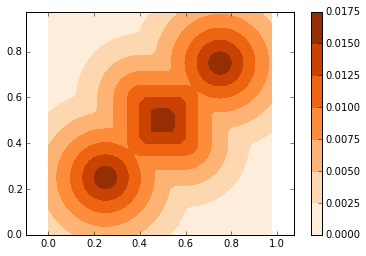

In [43]:
delta = 0.025
x = np.arange(0, 1.0, delta)
y = np.arange(0, 1.0, delta)
X, Y = np.meshgrid(x, y)
pts = np.vstack((X.flatten(), Y.flatten())).T
Z = np.asarray([sdf.sdf(p) for p in pts])
eps = 0.5
k = 0.1
C = np.asarray([c(z, eps, k) for z in Z])
Z = Z.reshape(X.shape)
C = C.reshape(X.shape)
norm = MidpointNormalize(midpoint=0.)
CS = plt.contourf(X, Y, Z, norm=norm, cmap=plt.cm.RdBu)
plt.axis('equal')
plt.colorbar()
plt.figure()
plt.axis('equal')
CS = plt.contourf(X, Y, C, cmap=plt.cm.Oranges)
plt.colorbar()

In [ ]:
class CHOMP(object):
    def __init__(self, sdf):
        self.sdf = sdf
    def set_traj(self, traj):
        '''
        Sets the trajectory and some internal members.
        Useful if you just want to compute costs and gradients
        without optimizing
        '''
        self.traj = traj
        self.npts, self.ndim = traj[1:-1,:].shape
    def hessian(self):
        '''
        Computes the [partial] Hessian for the optimization, which is
        the Reimannian metric for smoothness
        '''
        hess = np.diag([2]*self.npts*self.ndim)
        rows = np.arange(0, self.npts*self.ndim - self.ndim)
        cols = np.arange(self.ndim, self.npts*self.ndim)
        hess[rows, cols] = -1
        hess[cols, rows] = -1
        return hess
    def jacobian(self):
        '''
        Computes the gradient of the smoothness cost
        '''
        grad = 2*self.traj[1:-1,:] - self.traj[2:,:] - self.traj[0:-2,:]
        return grad
    def cost(self):
        '''
        Computes the smoothness cost
        '''
        fsmooth = 0.5*np.sum([np.linalg.norm(self.traj[i,:] - self.traj[i-1,:])**2 for i in range(1, self.npts+2)])
        return fsmooth
    def optimize(self, x0):
        self.set_traj(x0)
        hess = self.hessian()
        def unflat(x):
            traj = x.reshape(x.shape[0]/self.ndim, self.ndim)
            self.traj[1:-1,:] = traj
        def flat(y):
            return y.flatten()
        def fn(x):
            unflat(x)
            return self.cost() 
        def jac(x):
            unflat(x)
            return flat(self.jacobian())
        def hessian(x):
            return hess
        tall = []
        def fn_call(x):
            from copy import deepcopy
            unflat(x)
            tall.append(deepcopy(self.traj))    
        res = scipy.optimize.minimize(fn, flat(self.traj[1:-1,:]), method='Newton-CG', jac=jac, hess=hessian, callback=fn_call)
        return res, np.asarray(tall)

In [ ]:
sidd = CHOMP(sdf)
ndim = 2
npts = 10
xs = np.zeros(ndim)
xt = np.ones(ndim)
x0 = np.random.rand(npts, ndim)
x0 = np.vstack((xs, x0, xt))
res, tall = sidd.optimize(x0)
print res['message']
print 'Evals:', res['njev'], '+', res['nfev'], '+', res['nhev'], '=', res['njev'] + res['nfev'] + res['nhev']

In [ ]:
def animate_traj(tall, fname='traj.mp4'):
    fig = plt.figure()
    def update(i):
        traj = tall[i]
        plt.cla()
        plt.axis([-0.2, 1.2, -0.2, 1.2])
        return plt.plot(traj[:, 0], traj[:, 1], 'ro-')
    ani = animation.FuncAnimation(fig, update, frames=len(tall))
    ani.save(fname)
    return ani

In [ ]:
def plot_traj(tall):
    import matplotlib.pyplot as plt
    import matplotlib.animation as animation
    import matplotlib.cm as cm
    numplot = 10.
    mycm = cm.RdYlGn
    for j, i in enumerate(np.linspace(0, xall.shape[0]-1, numplot, dtype=np.int64)):
        traj = tall[i]
        im = plt.plot(traj[:, 0], traj[:, 1], 'o-', color=mycm(j/numplot))
    plt.axis([-0.2, 1.2, -0.2, 1.2])

In [ ]:
plot_traj(tall)

In [ ]:
ani = animate_traj(tall)